In [2]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn
from sklearn import linear_model
import numpy as np
import pickle
import xgboost as xgb
import time

# pull data from Mongodb server
client = MongoClient('127.0.0.1', 3001)
db = client.meteor
images = list(db.facebook.find({}))

df = pd.DataFrame(images)
df = df.dropna(subset = ['normalized_log_likes'])
# drop data with missing username
df = df[df['user'] != 'profile.php']

# build numpy array from DataFrame
likes = np.zeros((len(df), 1))
pool = np.zeros((len(df), 2048))
categories = np.zeros((len(df), 1008))
facedata = np.zeros((len(df), 3))

j = 0
for i in df.index:
    likes[j, :] = df['normalized_log_likes'][i]
    pool[j, :] = df['inception_pool'][i]
    categories[j, :] = df['inception_classification'][i]
    facedata[j, :] = [df['faces'][i]['num'], df['faces'][i]['total'], df['faces'][i]['largest']]
    j += 1

users = set(df['user'])
users = list(users)
user_hot = np.zeros((len(df), len(users)))

j = 0
for i in df.index:
    user_index = users.index(df['user'][i])
    user_hot[j, user_index] = 1
    j += 1
    
predictors = np.hstack((pool, facedata))

In [37]:
def split_datasets(users, user_hot, predictors, likes, seed=5):
    print('Seed value is: ' + str(seed))
    np.random.seed(seed)

    # choose 100 random users to be the test set
    test_users = np.random.choice(len(users), 50)
    # choose ~100 random users to be the validation set
    validation_users = [v for v in np.random.choice(len(users), 52) if v not in test_users]

    test_set = np.any(user_hot[:, test_users], axis = 1).nonzero()[0]
    test_set_add = np.random.choice(len(predictors), 800, replace=False)
    test_set = np.asarray(list(set(np.append(test_set, test_set_add).tolist())))

    validation_set = np.any(user_hot[:, validation_users], axis = 1).nonzero()[0]
    validation_set_add = [v for v in np.random.choice(len(predictors), 810, replace=False) if v not in test_set]
    validation_set = np.asarray(list(set(np.append(validation_set, validation_set_add).tolist())))

    training_set = [v for v in range(len(predictors)) if v not in test_set and v not in validation_set]

    print("Training set length: " + str(len(training_set)))
    print("Test set length: " + str(len(test_set)))
    print("Validation set length: " + str(len(validation_set)))
    
    return (training_set, predictors[training_set, :], likes[training_set], user_hot[training_set, :], predictors[validation_set, :], likes[validation_set], user_hot[validation_set, :], test_users)

#     # build training dataset
#     # put data in xgboost format
#     training_xgb = xgb.DMatrix(predictors[training_set, :], label=likes[training_set])
#     training_xgb_with_user = xgb.DMatrix(user_hot[training_set, :], label=likes[training_set])
#     validation_xgb = xgb.DMatrix(predictors[validation_set, :], label=likes[validation_set])
#     validation_xgb_with_user = xgb.DMatrix(user_hot[validation_set, :], label=likes[validation_set])
#     test_xgb = xgb.DMatrix(predictors[test_set, :], label=likes[test_set])
    
#     return (training_xgb, validation_xgb, test_xgb, training_xgb_with_user, validation_xgb_with_user)

In [6]:
(training_xgb, validation_xgb, test_xgb) = split_datasets(users, user_hot, responses, face_data, likes)

Training set length: 68168
Test set length: 1817
Validation set length: 1592


In [39]:
param = {'max_depth':1, 'eta':1.0, 'silent':1, 'objective':'reg:linear', 'nthread': 4, 'subsample': 1.0, 'eval_metric': 'rmse'}

bst = xgb.train(param, training_xgb, 50000, evals=[(validation_xgb, 'validation')], early_stopping_rounds=200, verbose_eval=50)

In [13]:
param = {'max_depth':3, 'eta':0.1, 'silent':1, 'objective':'reg:linear', 'nthread': 4, 'subsample': 1.0, 'eval_metric': 'rmse'}
bst = xgb.train(param, training_xgb, 238, evals=[(validation_xgb, 'validation')], early_stopping_rounds=50, verbose_eval=50)

[0]	validation-rmse:0.678911
Will train until validation-rmse hasn't improved in 50 rounds.
[50]	validation-rmse:0.479875
[100]	validation-rmse:0.478983
[150]	validation-rmse:0.478761
[200]	validation-rmse:0.478445


In [59]:
param = {'max_depth':3, 'eta':0.02, 'silent':1, 'objective':'reg:linear', 'nthread': 4, 'subsample': 0.6, 'eval_metric': 'rmse'}
bst = xgb.train(param, training_xgb, 50000, evals=[(validation_xgb, 'validation')], early_stopping_rounds=50, verbose_eval=50)

[0]	validation-rmse:0.710411
Will train until validation-rmse hasn't improved in 50 rounds.
[50]	validation-rmse:0.530697
[100]	validation-rmse:0.498117
[150]	validation-rmse:0.491185
[200]	validation-rmse:0.488947
[250]	validation-rmse:0.487888
[300]	validation-rmse:0.486974
[350]	validation-rmse:0.48641
[400]	validation-rmse:0.485759
[450]	validation-rmse:0.485287
[500]	validation-rmse:0.484794
[550]	validation-rmse:0.484221
[600]	validation-rmse:0.483927
[650]	validation-rmse:0.483793
[700]	validation-rmse:0.483428
[750]	validation-rmse:0.483236
[800]	validation-rmse:0.482839
[850]	validation-rmse:0.482745
[900]	validation-rmse:0.482335
[950]	validation-rmse:0.482064
[1000]	validation-rmse:0.481947
Stopping. Best iteration:
[997]	validation-rmse:0.481921



In [42]:
def calculate_rmse(actual, pred):
    return np.sqrt(np.mean(np.square(np.ravel(actual) - np.ravel(pred))))

In [33]:
validation_xgb.get_label()

array([ 0.29916766,  0.04081395,  0.24318463, ...,  0.54747152,
        0.69200671,  0.36116186], dtype=float32)

rmse:0.47819
r^2: 0.0473492009411


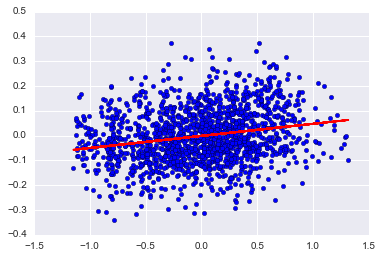

In [39]:
def evaluate_performance(model, test_dataset):
    ypred = model.predict(test_dataset)
    y = test_dataset.get_label().reshape(-1, 1)
    plt.scatter(y, ypred)
    print('rmse:' + str(calculate_rmse(y, ypred)))

    lin = linear_model.LinearRegression()
    lin.fit(y, ypred)
    plt.plot(y, y * lin.coef_ + lin.intercept_, 'r')
    print("r^2: " + str(lin.score(y, ypred)))

evaluate_performance(validation_xgb)

rmse:0.440146
r^2: 0.073531268141


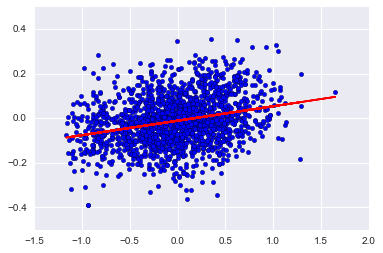

In [40]:
evaluate_performance(test_xgb)

rmse:0.460824
r^2: 0.160420128021


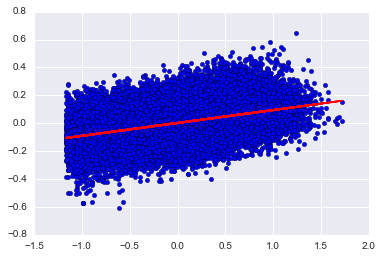

In [41]:
evaluate_performance(training_xgb)

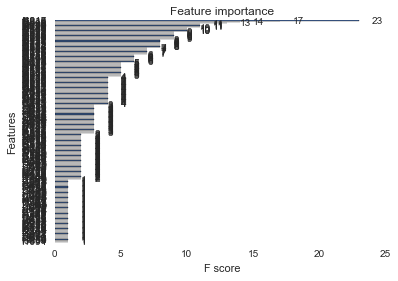

In [98]:
ax = xgb.plot_importance(bst)


rmse:0.323258
r^2: 1.0
rmse:0.540574
r^2: 1.0
rmse:0.481736
r^2: 0.0141372277038
rmse:0.831957
r^2: 2.81062739749e-09
rmse:0.47463
r^2: 0.081260678789
rmse:0.369493
r^2: 1.0
rmse:0.605837
r^2: 1.0
rmse:0.501387
r^2: 0.0105505749888
rmse:0.488059
r^2: 0.0316985856933
rmse:0.673501
r^2: 1.0
rmse:0.635641
r^2: 0.139809716912
rmse:0.322892
r^2: 0.951840352137
rmse:0.154569
r^2: 1.0
rmse:0.603477
r^2: 1.0
rmse:0.306795
r^2: 1.0
rmse:0.219932
r^2: 1.0
rmse:0.231833
r^2: 1.0
rmse:0.333421
r^2: 1.0
rmse:0.37005
r^2: 0.0517223494428
rmse:0.762628
r^2: 1.0
rmse:0.350628
r^2: 0.0728489145125
rmse:0.298505
r^2: 0.0712417048988
rmse:0.35446
r^2: 0.535114614233
rmse:0.666777
r^2: 0.1870902333
rmse:0.635223
r^2: 1.0
rmse:0.414
r^2: 0.0438130683959
rmse:0.51218
r^2: 1.0
rmse:0.935075
r^2: 1.0
rmse:0.324479
r^2: 0.234323817517
rmse:0.341384
r^2: 1.0
rmse:0.267725
r^2: 0.301679990103
rmse:0.497463
r^2: 0.849517610457
rmse:0.589295
r^2: 0.893574619772
rmse:1.06131
r^2: 1.0
rmse:0.198965
r^2: 1.0
rmse:0.4

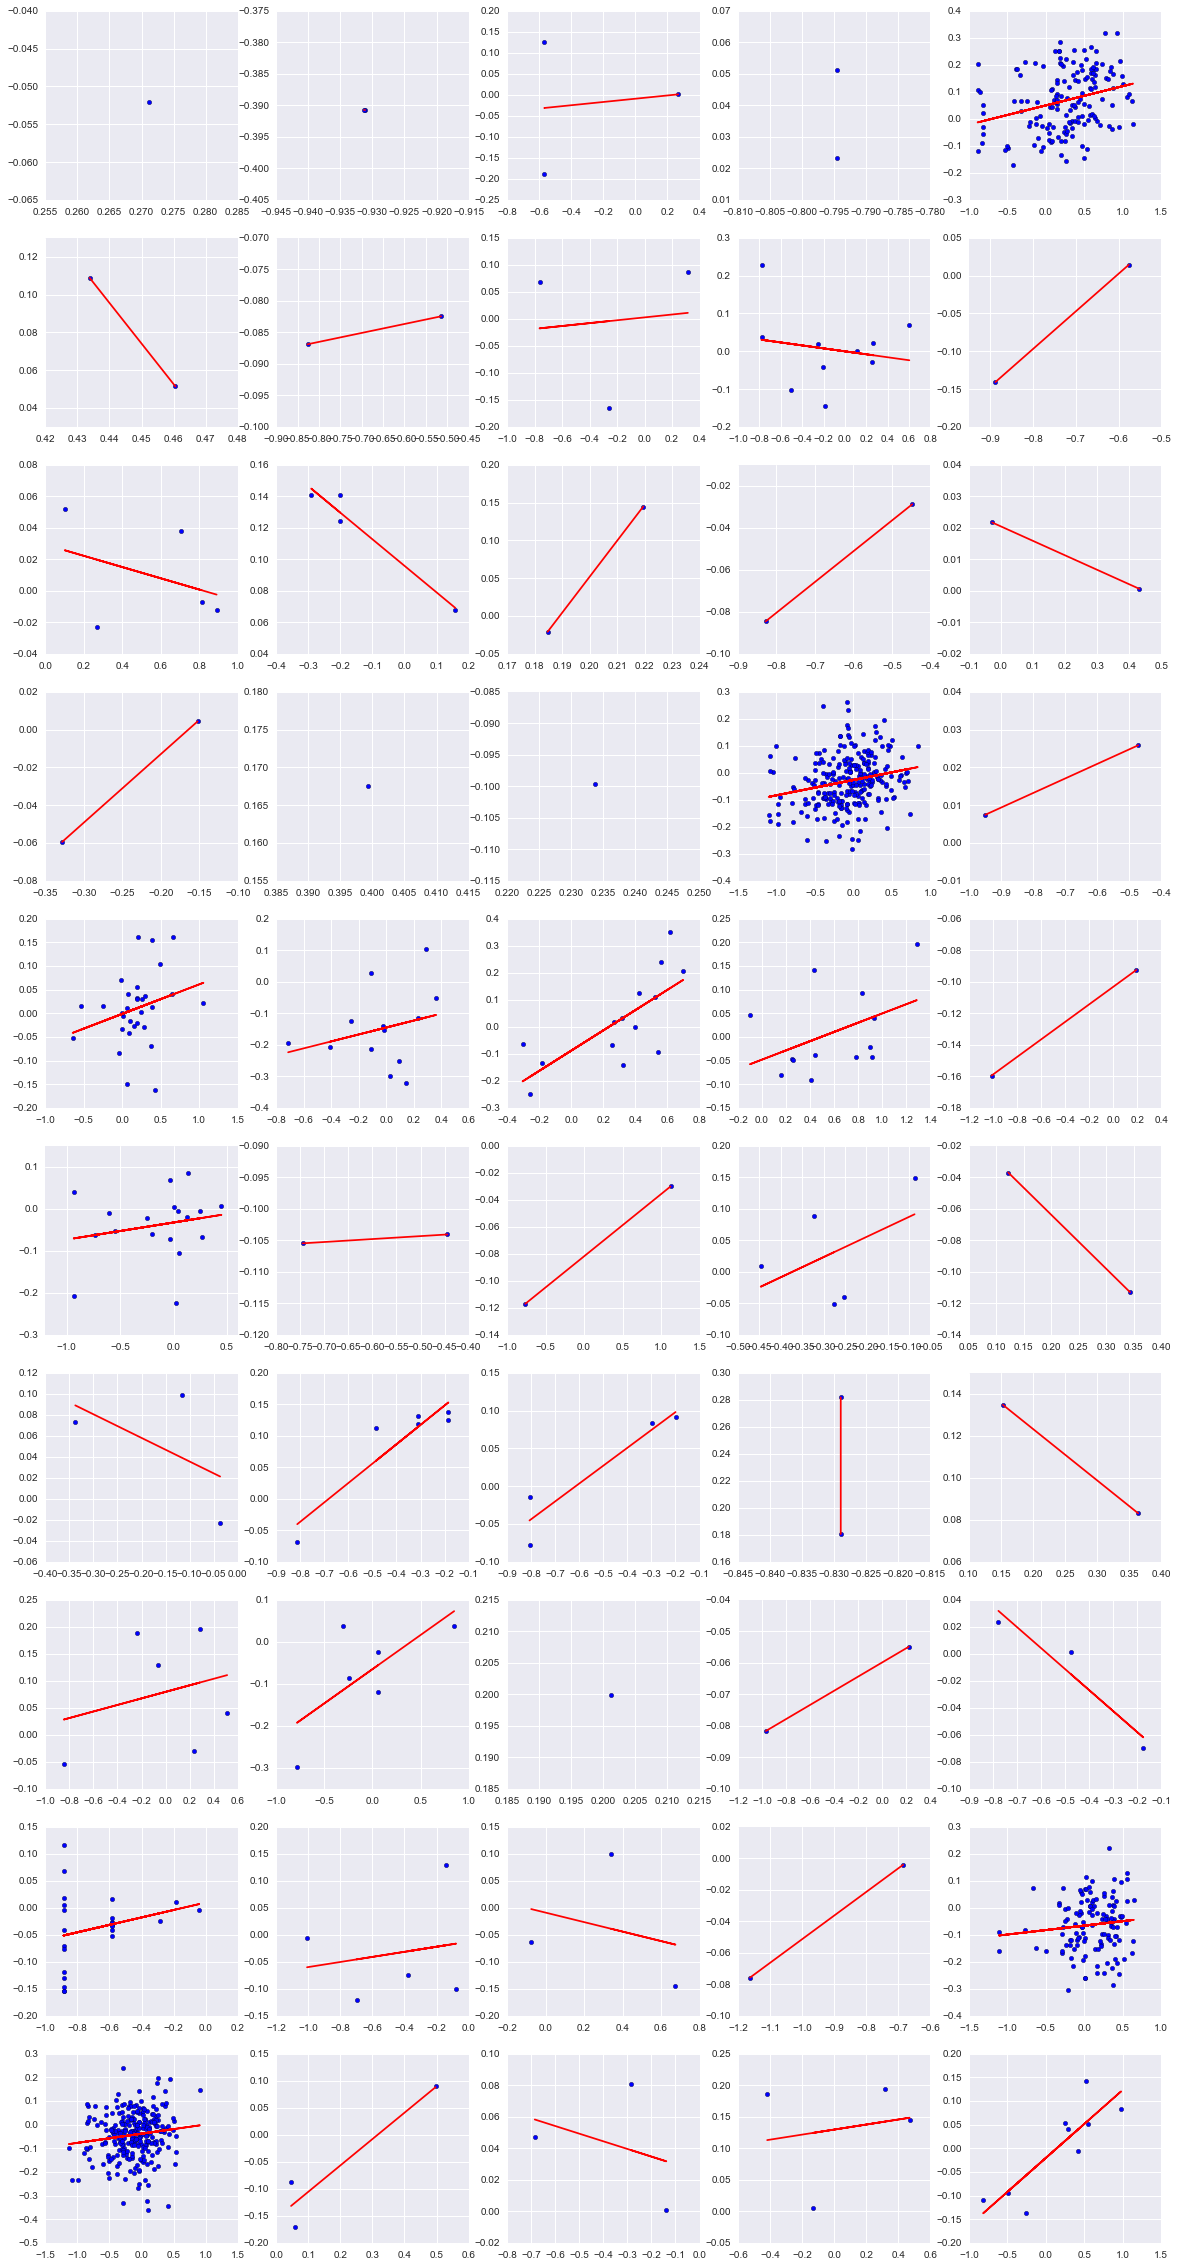

In [69]:
plt.figure(figsize=(20, 40))
for i in range(50):
    plt.subplot(10, 5, i+1)
    user_test_set = np.any(user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
    user_test_xgb = xgb.DMatrix(np.hstack((responses[user_test_set, :], facedata[user_test_set, :])), label=likes[user_test_set])
    evaluate_performance(bst, user_test_xgb)

# Attempt to normalize out user influence

In [74]:
user_lin = linear_model.LinearRegression().fit(np.hstack((responses, facedata, user_hot)), likes)

user_bias_prediction = user_lin.predict(np.hstack((responses * 0, facedata*0, user_hot)))

normalized_likes = likes - user_bias_prediction

In [95]:
(new_train, new_validate, new_test, new_train_with_user, new_validation_with_user) = split_datasets(users, user_hot, predictors, likes, seed=5)

Seed value is: 5
Training set length: 68168
Test set length: 1817
Validation set length: 1592


In [83]:
param = {'max_depth':3, 'eta':0.1, 'silent':1, 'objective':'reg:linear', 'nthread': 4, 'subsample': 1.0, 'eval_metric': 'rmse'}
bst = xgb.train(param, new_train, 600, evals=[(new_validate, 'validation')], early_stopping_rounds=50, verbose_eval=50)

[0]	validation-rmse:0.567985
Will train until validation-rmse hasn't improved in 50 rounds.
[50]	validation-rmse:0.374682
[100]	validation-rmse:0.373792
[150]	validation-rmse:0.37308
[200]	validation-rmse:0.372845
[250]	validation-rmse:0.372212
[300]	validation-rmse:0.372207
[350]	validation-rmse:0.371505
[400]	validation-rmse:0.371561
Stopping. Best iteration:
[364]	validation-rmse:0.371421



rmse:0.335081
r^2: 1.0
rmse:0.697389
r^2: 1.0
rmse:0.511391
r^2: 0.116575642735
rmse:0.795839
r^2: 7.58529117295e-09
rmse:0.465904
r^2: 0.0694429977043
rmse:0.258275
r^2: 1.0
rmse:0.674124
r^2: 1.0
rmse:0.545734
r^2: 0.0221906884367
rmse:0.498185
r^2: 0.0113983288137
rmse:0.759891
r^2: 1.0
rmse:0.573805
r^2: 0.3630453526
rmse:0.342794
r^2: 0.681239547523
rmse:0.124569
r^2: 1.0
rmse:0.631675
r^2: 1.0
rmse:0.167532
r^2: 1.0
rmse:0.323555
r^2: 1.0
rmse:0.15648
r^2: 1.0
rmse:0.364139
r^2: 1.0
rmse:0.367552
r^2: 0.0973487405421
rmse:0.762518
r^2: 1.0
rmse:0.311712
r^2: 0.181223600805
rmse:0.253057
r^2: 0.228036979592
rmse:0.356128
r^2: 0.501754891783
rmse:0.67248
r^2: 0.158907140015
rmse:0.705344
r^2: 1.0
rmse:0.436152
r^2: 0.0215771082162
rmse:0.607059
r^2: 1.0
rmse:0.935119
r^2: 1.0
rmse:0.361031
r^2: 0.00855482418394
rmse:0.356116
r^2: 1.0
rmse:0.335852
r^2: 0.0168381750814
rmse:0.502047
r^2: 0.872059400892
rmse:0.591612
r^2: 0.448789897652
rmse:1.00259
r^2: 1.0
rmse:0.150218
r^2: 1.0
rm

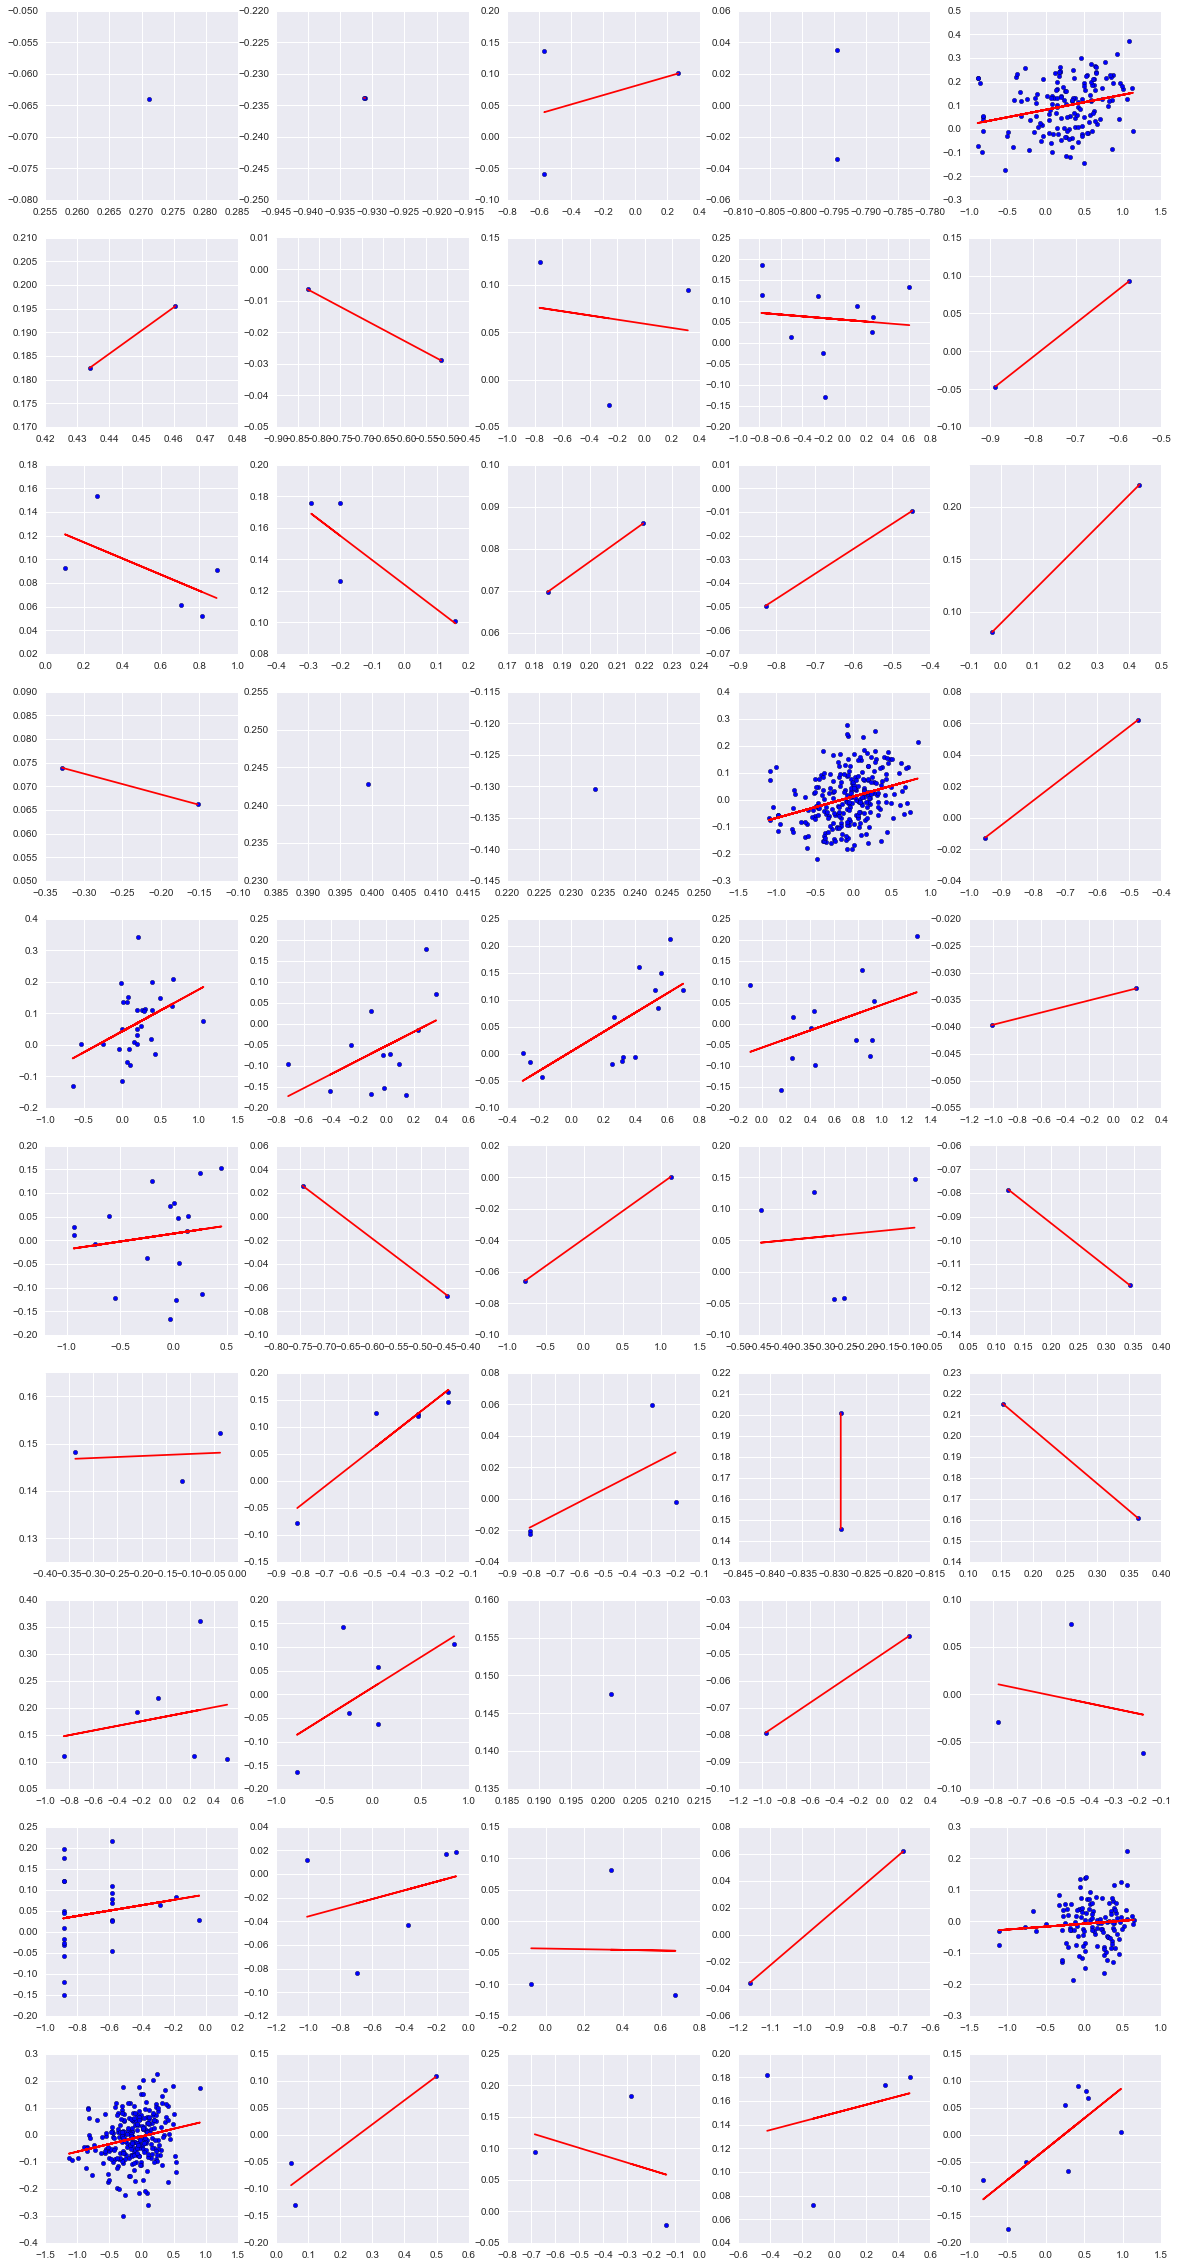

In [85]:
plt.figure(figsize=(20, 40))
for i in range(50):
    plt.subplot(10, 5, i+1)
    user_test_set = np.any(user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
    user_test_xgb = xgb.DMatrix(np.hstack((responses[user_test_set, :], facedata[user_test_set, :])), label=likes[user_test_set])
    evaluate_performance(user_test_xgb)

In [96]:
param = {'max_depth':1, 'eta':0.1, 'silent':1, 'objective':'reg:linear', 'nthread': 4, 'subsample': 1.0, 'eval_metric': 'rmse'}

bst = xgb.train(param, new_train_with_user, 6000, evals=[(new_validation_with_user, 'validation')], early_stopping_rounds=50, verbose_eval=50)

[0]	validation-rmse:0.680577
Will train until validation-rmse hasn't improved in 50 rounds.
[50]	validation-rmse:0.486301
[100]	validation-rmse:0.485356
[150]	validation-rmse:0.484646
[200]	validation-rmse:0.48402
[250]	validation-rmse:0.483742
[300]	validation-rmse:0.483311
[350]	validation-rmse:0.482937
[400]	validation-rmse:0.482693
[450]	validation-rmse:0.48245
[500]	validation-rmse:0.482199
[550]	validation-rmse:0.481982
[600]	validation-rmse:0.481847
[650]	validation-rmse:0.481611
[700]	validation-rmse:0.481507
[750]	validation-rmse:0.481439
[800]	validation-rmse:0.481248
[850]	validation-rmse:0.481106
[900]	validation-rmse:0.480909
[950]	validation-rmse:0.480957
Stopping. Best iteration:
[900]	validation-rmse:0.480909



rmse:0.297979
r^2: 1.0
rmse:0.827732
r^2: 1.0
rmse:0.467625
r^2: 0.27837575168
rmse:0.756577
r^2: -3.19945765437e-08
rmse:0.492886
r^2: 0.049460716885
rmse:0.366061
r^2: 1.0
rmse:0.616796
r^2: 1.0
rmse:0.483441
r^2: 0.21833101026
rmse:0.489739
r^2: 0.0984768576981
rmse:0.697607
r^2: 1.0
rmse:0.633255
r^2: 0.428863001632
rmse:0.276034
r^2: 0.965484713302
rmse:0.187769
r^2: 1.0
rmse:0.593485
r^2: 1.0
rmse:0.223494
r^2: 1.0
rmse:0.257601
r^2: 1.0
rmse:0.264871
r^2: 1.0
rmse:0.307727
r^2: 1.0
rmse:0.371389
r^2: 0.0541264499737
rmse:0.76221
r^2: 1.0
rmse:0.344947
r^2: 0.122580802914
rmse:0.277259
r^2: 0.0578536035905
rmse:0.392275
r^2: 0.338886433154
rmse:0.683946
r^2: 0.136937502884
rmse:0.732441
r^2: 1.0
rmse:0.416122
r^2: 0.0651294172169
rmse:0.555882
r^2: 1.0
rmse:0.948731
r^2: 1.0
rmse:0.332357
r^2: 0.11674958921
rmse:0.322769
r^2: 1.0
rmse:0.266741
r^2: 0.20910648752
rmse:0.45013
r^2: 0.516239860799
rmse:0.579954
r^2: 0.438095908111
rmse:1.00282
r^2: 1.0
rmse:0.194151
r^2: 1.0
rmse:0.

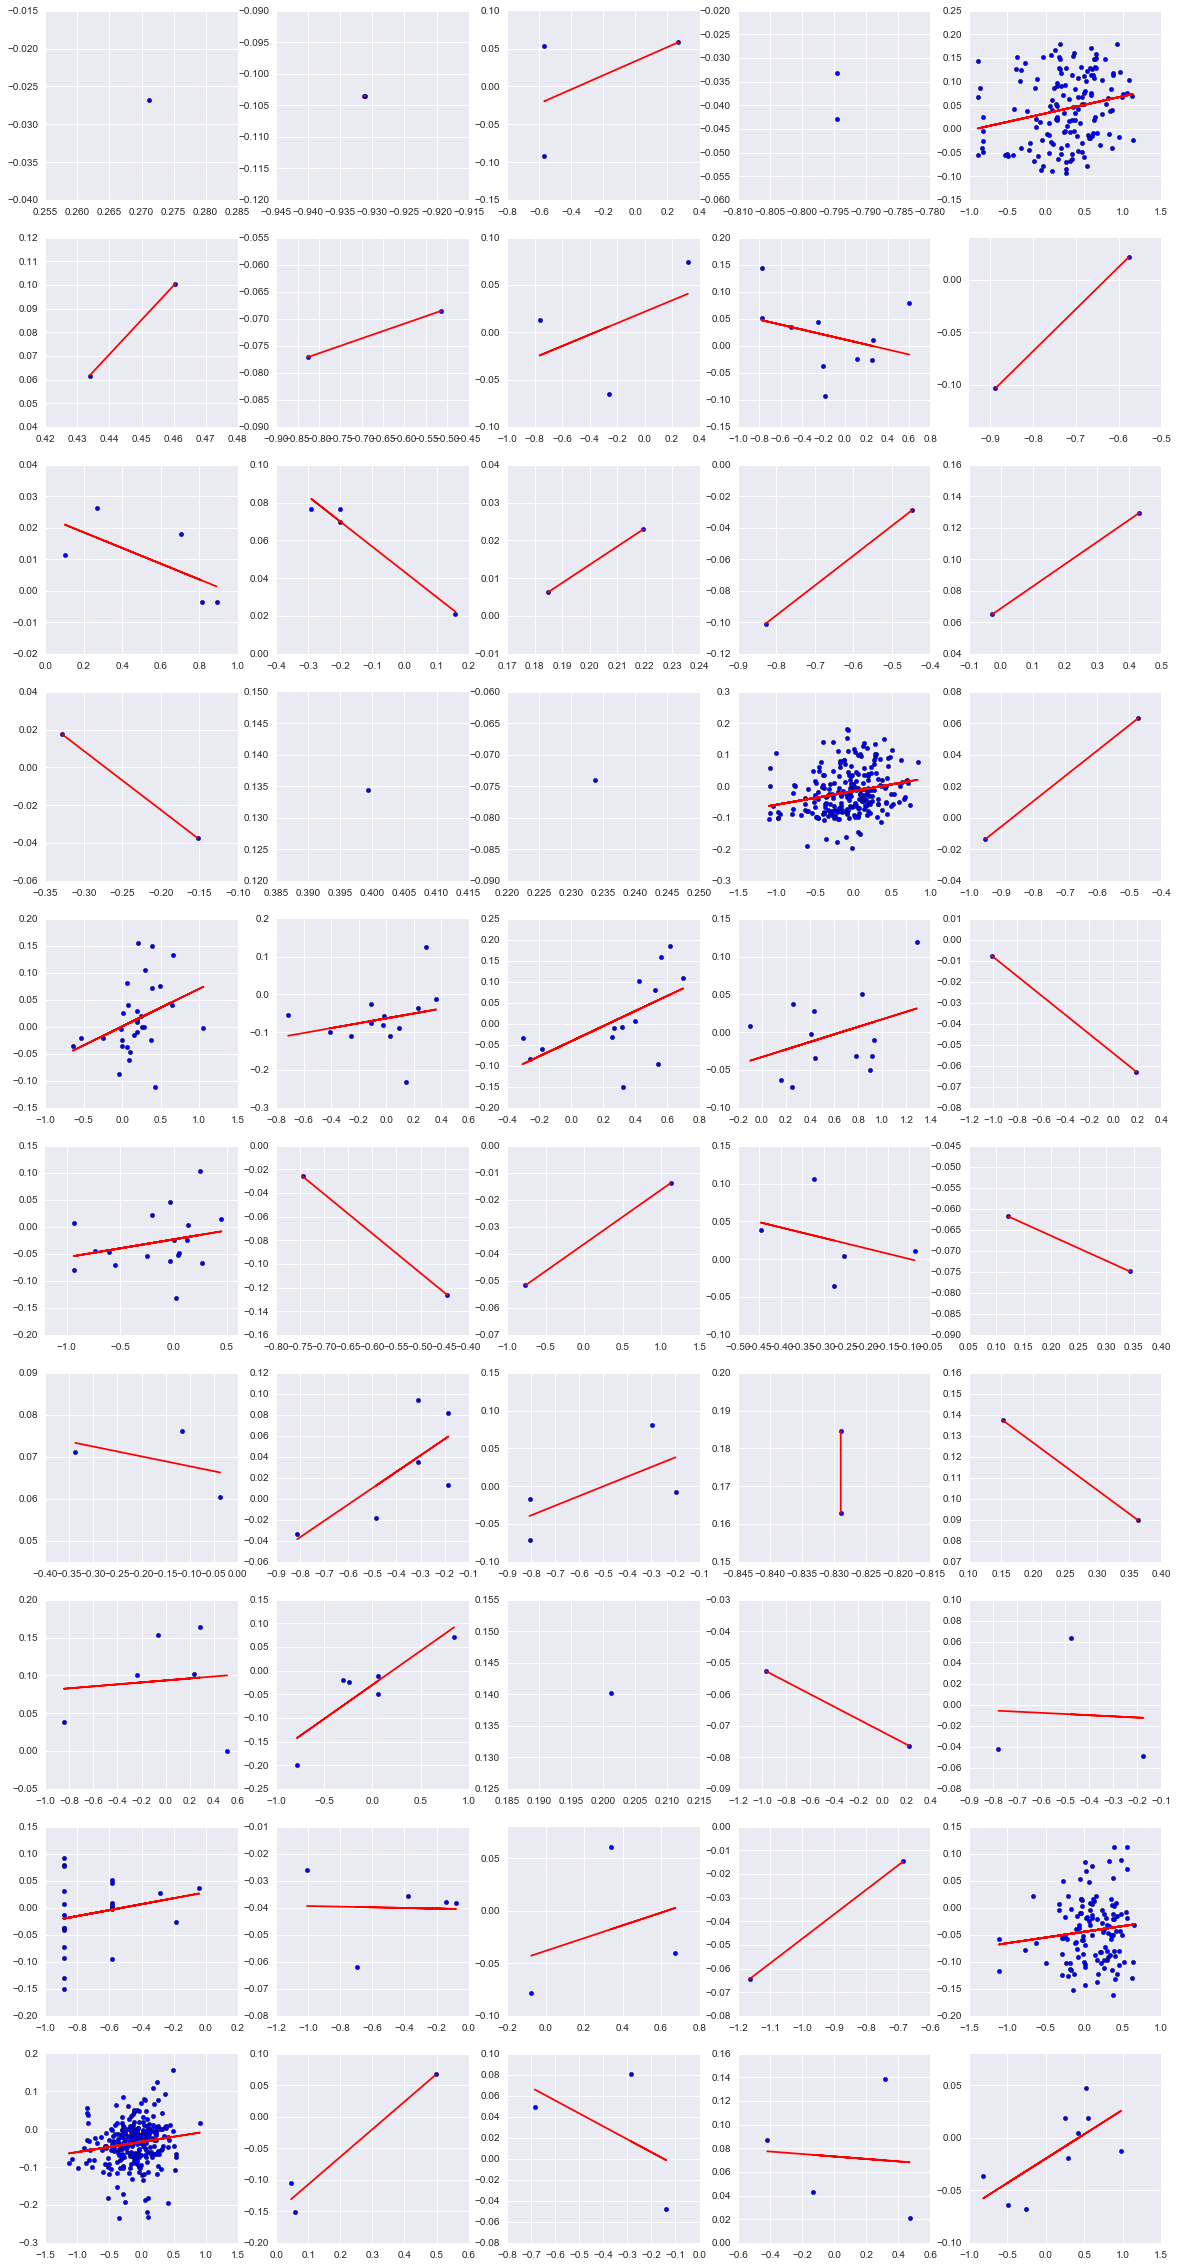

In [97]:
plt.figure(figsize=(20, 40))
for i in range(50):
    plt.subplot(10, 5, i+1)
    user_test_set = np.any(user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
    user_test_xgb = xgb.DMatrix(np.hstack((responses[user_test_set, :], facedata[user_test_set, :], 0*user_hot[user_test_set, :])), label=likes[user_test_set])
    evaluate_performance(user_test_xgb)

Seed value is: 5
Training set length: 68168
Test set length: 1817
Validation set length: 1592


In [109]:
(new_train, new_validate, new_test, user_train, user_validation) = split_datasets(users, user_hot, predictors, likes, seed=5)

starting_likes = new_train.get_label()
user_model = []
inception_model = []

for i in range(200):
    param = {'max_depth':3, 'eta':0.1, 'silent':1, 'objective':'reg:linear', 'nthread': 1, 'subsample': 1.0, 'eval_metric': 'rmse'}
    inception_bst = xgb.train(param, new_train, 1)
    inception_likes = inception_bst.predict(new_train)
    
    param = {'max_depth':1, 'eta':0.1, 'silent':1, 'objective':'reg:linear', 'nthread': 1, 'subsample': 1.0, 'eval_metric': 'rmse'}
    user_bst = xgb.train(param, user_train, 1)
    user_likes = user_bst.predict(user_train)
    
    # what I should really do is take just one of these based on which one makes the biggest improvement to training error
    new_likes = new_train.get_label() - inception_likes*0.5 - user_likes*0.5
    new_train.set_label(new_likes)
    user_train.set_label(new_likes)
    
    inception_model.append(inception_bst)
    user_model.append(user_bst)
    
    if i % 10 == 0:
        print('Iteration ' + str(i))
        predicted_likes = inception_model[0].predict(new_train) / len(inception_model)
        
        for j in range(1, len(inception_model)):
            predicted_likes += inception_model[j].predict(new_train) / len(inception_model)
        rmse = np.sqrt(np.mean(np.square(np.ravel(predicted_likes) - np.ravel(starting_likes))))
        
        print('rmse: ' + str(rmse))
              
        predicted_user_likes = user_model[0].predict(user_train) / len(user_model)
        for j in range(1, len(user_model)):
            predicted_user_likes += user_model[j].predict(user_train) / len(user_model)
        # why should this be 50-50???
        rmse = np.sqrt(np.mean(np.square(np.ravel(predicted_likes*0.5 + predicted_user_likes*0.5) - np.ravel(starting_likes))))
        
        print('rmse w/ user model: ' + str(rmse))
        
        predicted_likes = inception_model[0].predict(new_validate) / len(inception_model)
        
        for j in range(1, len(inception_model)):
            predicted_likes += inception_model[j].predict(new_validate) / len(inception_model)
        rmse = np.sqrt(np.mean(np.square(np.ravel(predicted_likes) - np.ravel(new_validate.get_label()))))
        
        print('rmse w/ validation set: ' + str(rmse))

Seed value is: 5
Training set length: 68168
Test set length: 1817
Validation set length: 1592
Iteration 0
rmse: 0.666524
rmse w/ user model: 0.666349
rmse w/ validation set: 0.678911
Iteration 10
rmse: 0.566861
rmse w/ user model: 0.566722
rmse w/ validation set: 0.574566
Iteration 20
rmse: 0.528662
rmse w/ user model: 0.528554
rmse w/ validation set: 0.53297
Iteration 30
rmse: 0.512747
rmse w/ user model: 0.512647
rmse w/ validation set: 0.514848
Iteration 40
rmse: 0.505347
rmse w/ user model: 0.505244
rmse w/ validation set: 0.506025
Iteration 50
rmse: 0.501529
rmse w/ user model: 0.501424
rmse w/ validation set: 0.501243
Iteration 60
rmse: 0.499359
rmse w/ user model: 0.499253
rmse w/ validation set: 0.498397
Iteration 70
rmse: 0.498029
rmse w/ user model: 0.497927
rmse w/ validation set: 0.496572
Iteration 80
rmse: 0.497161
rmse w/ user model: 0.497062
rmse w/ validation set: 0.495328
Iteration 90
rmse: 0.496568
rmse w/ user model: 0.496471
rmse w/ validation set: 0.49444
Iteration

rmse:0.248909
r^2: 1.0
rmse:0.953204
r^2: 1.0
rmse:0.50251
r^2: 0.910422141804
rmse:0.816575
r^2: 0.0
rmse:0.511138
r^2: 0.0360276699302
rmse:0.4241
r^2: 0.999999999148
rmse:0.710035
r^2: 1.0
rmse:0.51127
r^2: 0.691069284482
rmse:0.468672
r^2: 0.0475609184143
rmse:0.770224
r^2: 1.0
rmse:0.618337
r^2: 0.462767090189
rmse:0.233458
r^2: 0.959351842098
rmse:0.180311
r^2: 0.999999999945
rmse:0.686908
r^2: 1.0
rmse:0.291055
r^2: 0.999999999207
rmse:0.277031
r^2: 0.99999999999
rmse:0.376216
r^2: 1.0
rmse:0.211919
r^2: 1.0
rmse:0.388653
r^2: 0.0452103045804
rmse:0.771229
r^2: 1.0
rmse:0.35495
r^2: 0.236658045258
rmse:0.290127
r^2: 0.101849683486
rmse:0.416817
r^2: 0.384100081994
rmse:0.670404
r^2: 0.0285255605169
rmse:0.740983
r^2: 0.999999999848
rmse:0.444301
r^2: 0.0328118284622
rmse:0.634827
r^2: 0.999999999567
rmse:0.956617
r^2: 1.0
rmse:0.321193
r^2: 0.257186981571
rmse:0.237645
r^2: 1.0
rmse:0.226011
r^2: 0.493072749861
rmse:0.458457
r^2: 0.35585517199
rmse:0.617744
r^2: 0.244414961888
r

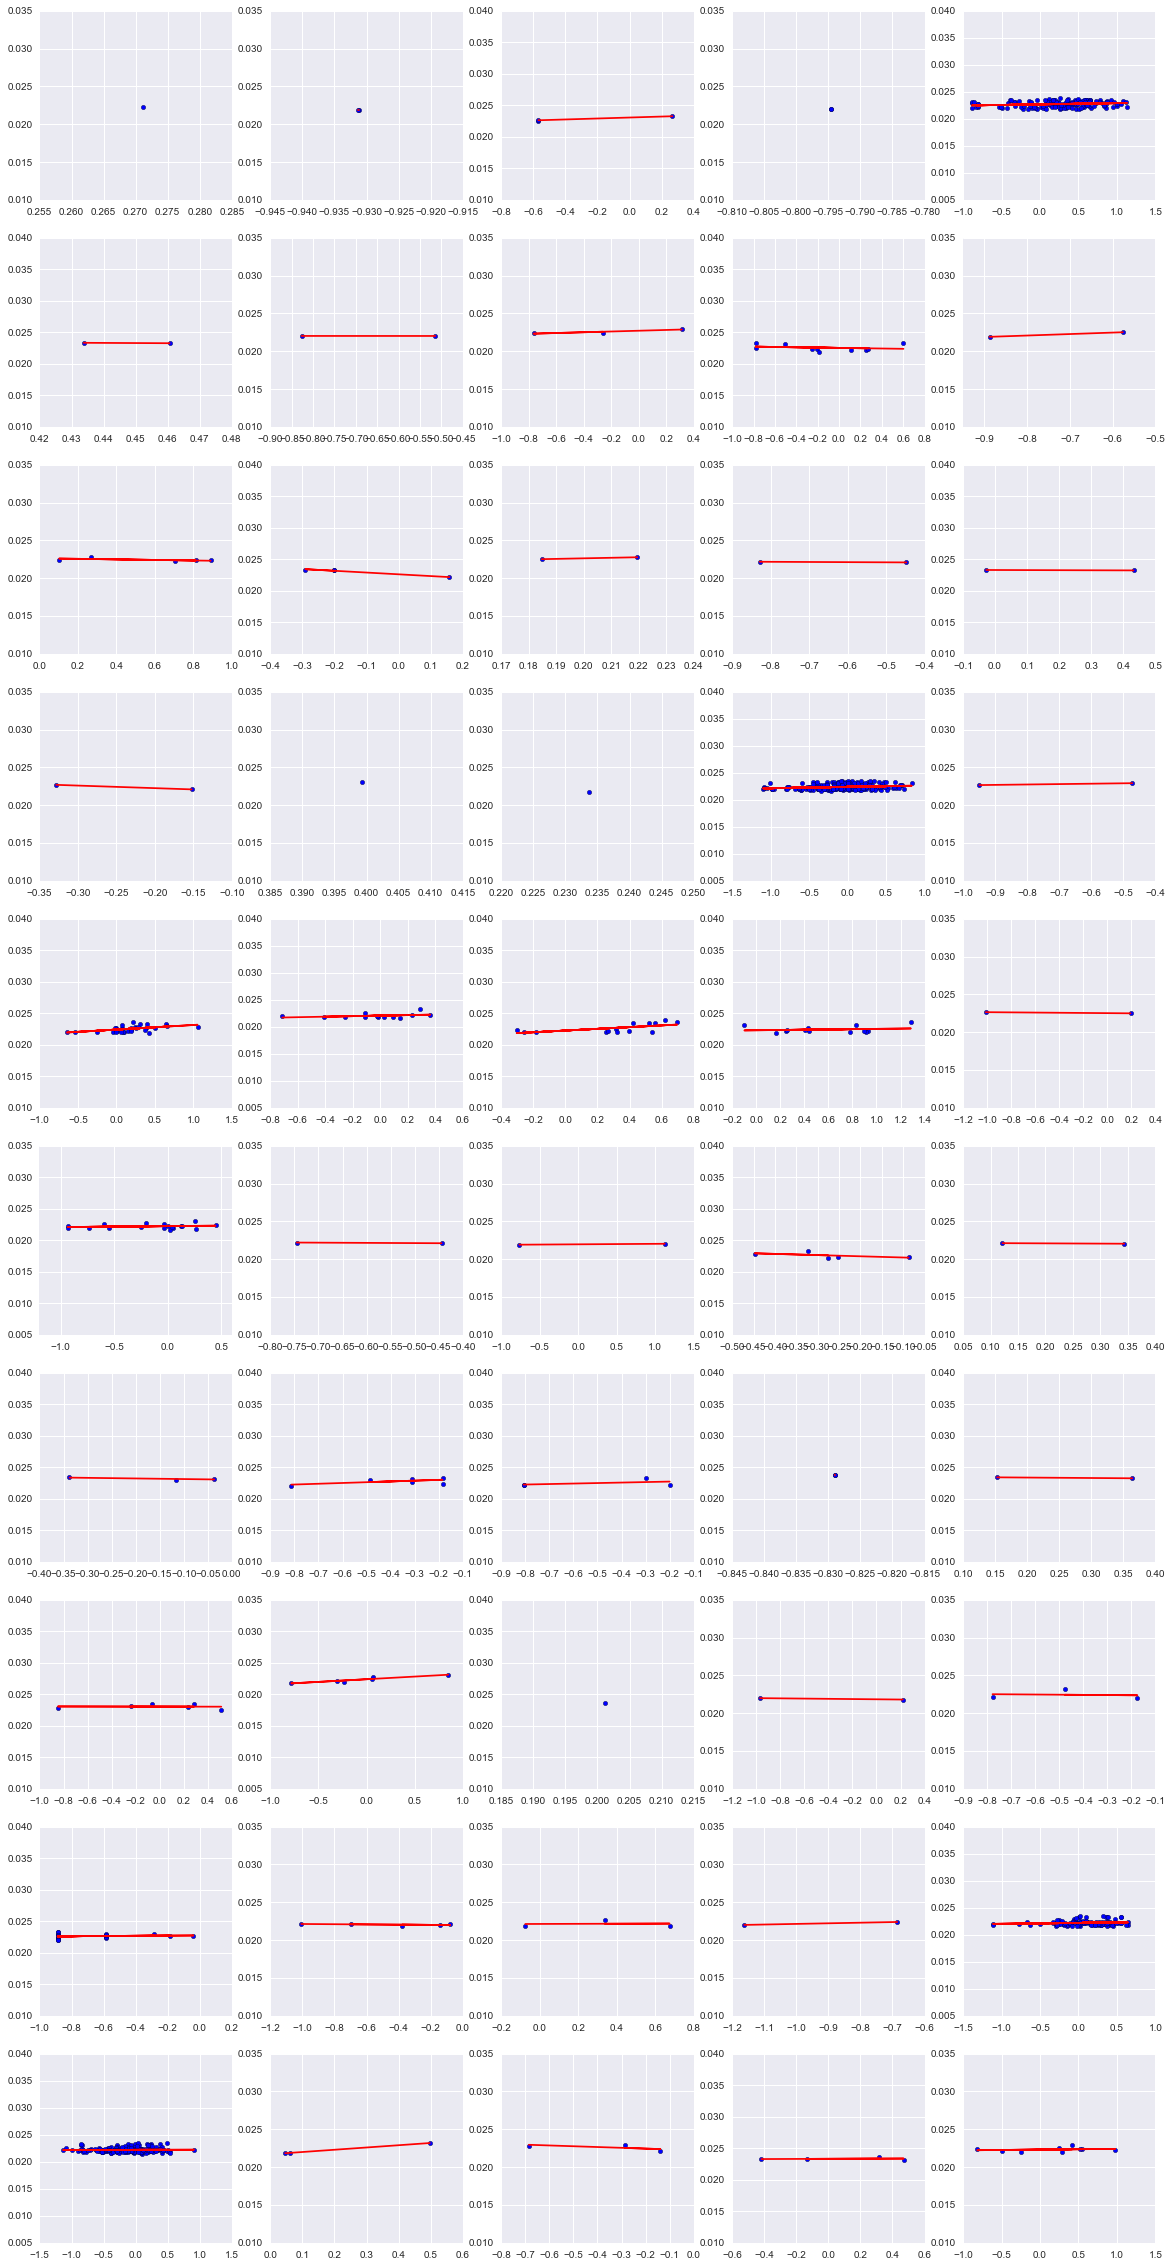

In [112]:
plt.figure(figsize=(20, 40))
for i in range(50):
    plt.subplot(10, 5, i+1)
    user_test_set = np.any(user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
    user_test_xgb = xgb.DMatrix(np.hstack((responses[user_test_set, :], facedata[user_test_set, :])), label=likes[user_test_set])
    
    ypred = inception_model[0].predict(user_test_xgb) / 200
    for j in range(1,200):
        ypred += inception_model[j].predict(user_test_xgb) / 200
        
    y = user_test_xgb.get_label().reshape(-1, 1)
    plt.scatter(y, ypred)
    print('rmse:' + str(calculate_rmse(y, ypred)))

    lin = linear_model.LinearRegression()
    lin.fit(y, ypred)
    plt.plot(y, y * lin.coef_ + lin.intercept_, 'r')
    print("r^2: " + str(lin.score(y, ypred)))


In [ ]:
# alternative idea:
#   each round, as I train, subtract off some of each user's mean residual
#      early tree splits may be poor, but if the learning is slow enough, maybe it won't matter?
#   look at sklearn gradient based model for opportunities to implement this

In [121]:
new_train.slice()

SyntaxError: invalid syntax (<ipython-input-121-3bdd782533dd>, line 1)

In [127]:
user_train.shape

(68168, 5863)

In [100]:
(training_set, train_data, train_label, user_train, validation_data, validation_label, user_validation, test_users) = split_datasets(users, user_hot, predictors, likes, seed=5)

Seed value is: 5
Training set length: 68168
Test set length: 1817
Validation set length: 1592


In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=10, max_depth=3, warm_start=True, verbose=1)

cumulative_mean_likes_for_user = np.zeros((5863,20))

for i in range(1, 20):
    gbr.set_params(n_estimators=i*10)
    gbr.fit(train_data, np.ravel(train_label))
    pred_likes = gbr.predict(train_data)
    
    for j in range(user_hot.shape[1]):
        like_error = np.mean(train_label[user_train[:,j] == 1] - pred_likes[user_train[:,j] == 1])
        train_label[user_train[:,j] == 1] -= like_error * 0.1
        cumulative_mean_likes_for_user[j, i] += like_error * 0.1

      Iter       Train Loss   Remaining Time 
         1           0.2087            4.95m
         2           0.2078            4.13m
         3           0.2071            3.59m
         4           0.2065            3.05m
         5           0.2059            2.52m
         6           0.2054            2.18m
         7           0.2050            1.70m
         8           0.2046            1.19m
         9           0.2043           35.70s
        10           0.2039            0.00s
      Iter       Train Loss   Remaining Time 
        11           0.1914            4.30m
        12           0.1911            3.73m
        13           0.1908            3.24m
        14           0.1906            2.76m
        15           0.1904            2.34m
        16           0.1902            1.86m
        17           0.1900            1.39m
        18           0.1897           55.74s
        19           0.1895           27.79s
        20           0.1894            0.00s
      It

In [23]:
pred_likes = train_label * 0

for j in range(user_hot.shape[1]):
    like_error = np.mean(train_label[user_train[:,j] == 1] - pred_likes[user_train[:,j] == 1])
    train_label[user_train[:,j] == 1] -= like_error * 0.1
    cumulative_mean_likes_for_user[j, i] += like_error * 0.1

ValueError: max must be larger than min in range parameter.

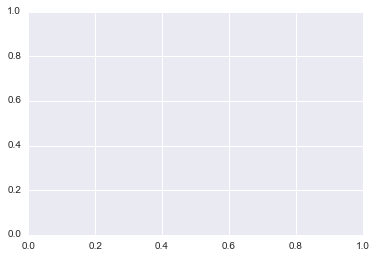

In [26]:
plt.hist(cumulative_mean_likes_for_user[:,0])

In [25]:
cumulative_mean_likes_for_user[:,0]

array([-0.13777354,  0.05576863, -0.16519819, ...,         nan,
               nan,         nan])

rmse:0.343747761971
r^2: 1.0
rmse:0.753330804321
r^2: 1.0
rmse:0.492583513109
r^2: 0.232578875713
rmse:0.785854926363
r^2: 1.0
rmse:0.48286886668
r^2: 0.0788069201985
rmse:0.332476446944
r^2: 1.0
rmse:0.635208176622
r^2: 1.0
rmse:0.515384204867
r^2: 1.99836820536e-06
rmse:0.488335467895
r^2: 0.0342866537097
rmse:0.683326573206
r^2: 1.0
rmse:0.602403970705
r^2: 0.190127806412
rmse:0.293238714193
r^2: 0.526994570502
rmse:0.180978487705
r^2: 1.0
rmse:0.622845864866
r^2: 1.0
rmse:0.208940244986
r^2: 1.0
rmse:0.284430569576
r^2: 1.0
rmse:0.251895217343
r^2: 1.0
rmse:0.353151944989
r^2: 1.0
rmse:0.363117145991
r^2: 0.0965999506718
rmse:0.734105746099
r^2: 1.0
rmse:0.33846301893
r^2: 0.193770926253
rmse:0.273617255828
r^2: 0.111691001471
rmse:0.381647030073
r^2: 0.549433822141
rmse:0.697117310846
r^2: 0.139298265139
rmse:0.6660526204
r^2: 1.0
rmse:0.41729494012
r^2: 0.0263143890568
rmse:0.573892558635
r^2: 1.0
rmse:0.976720110412
r^2: 1.0
rmse:0.323100828403
r^2: 0.0045846394532
rmse:0.379162

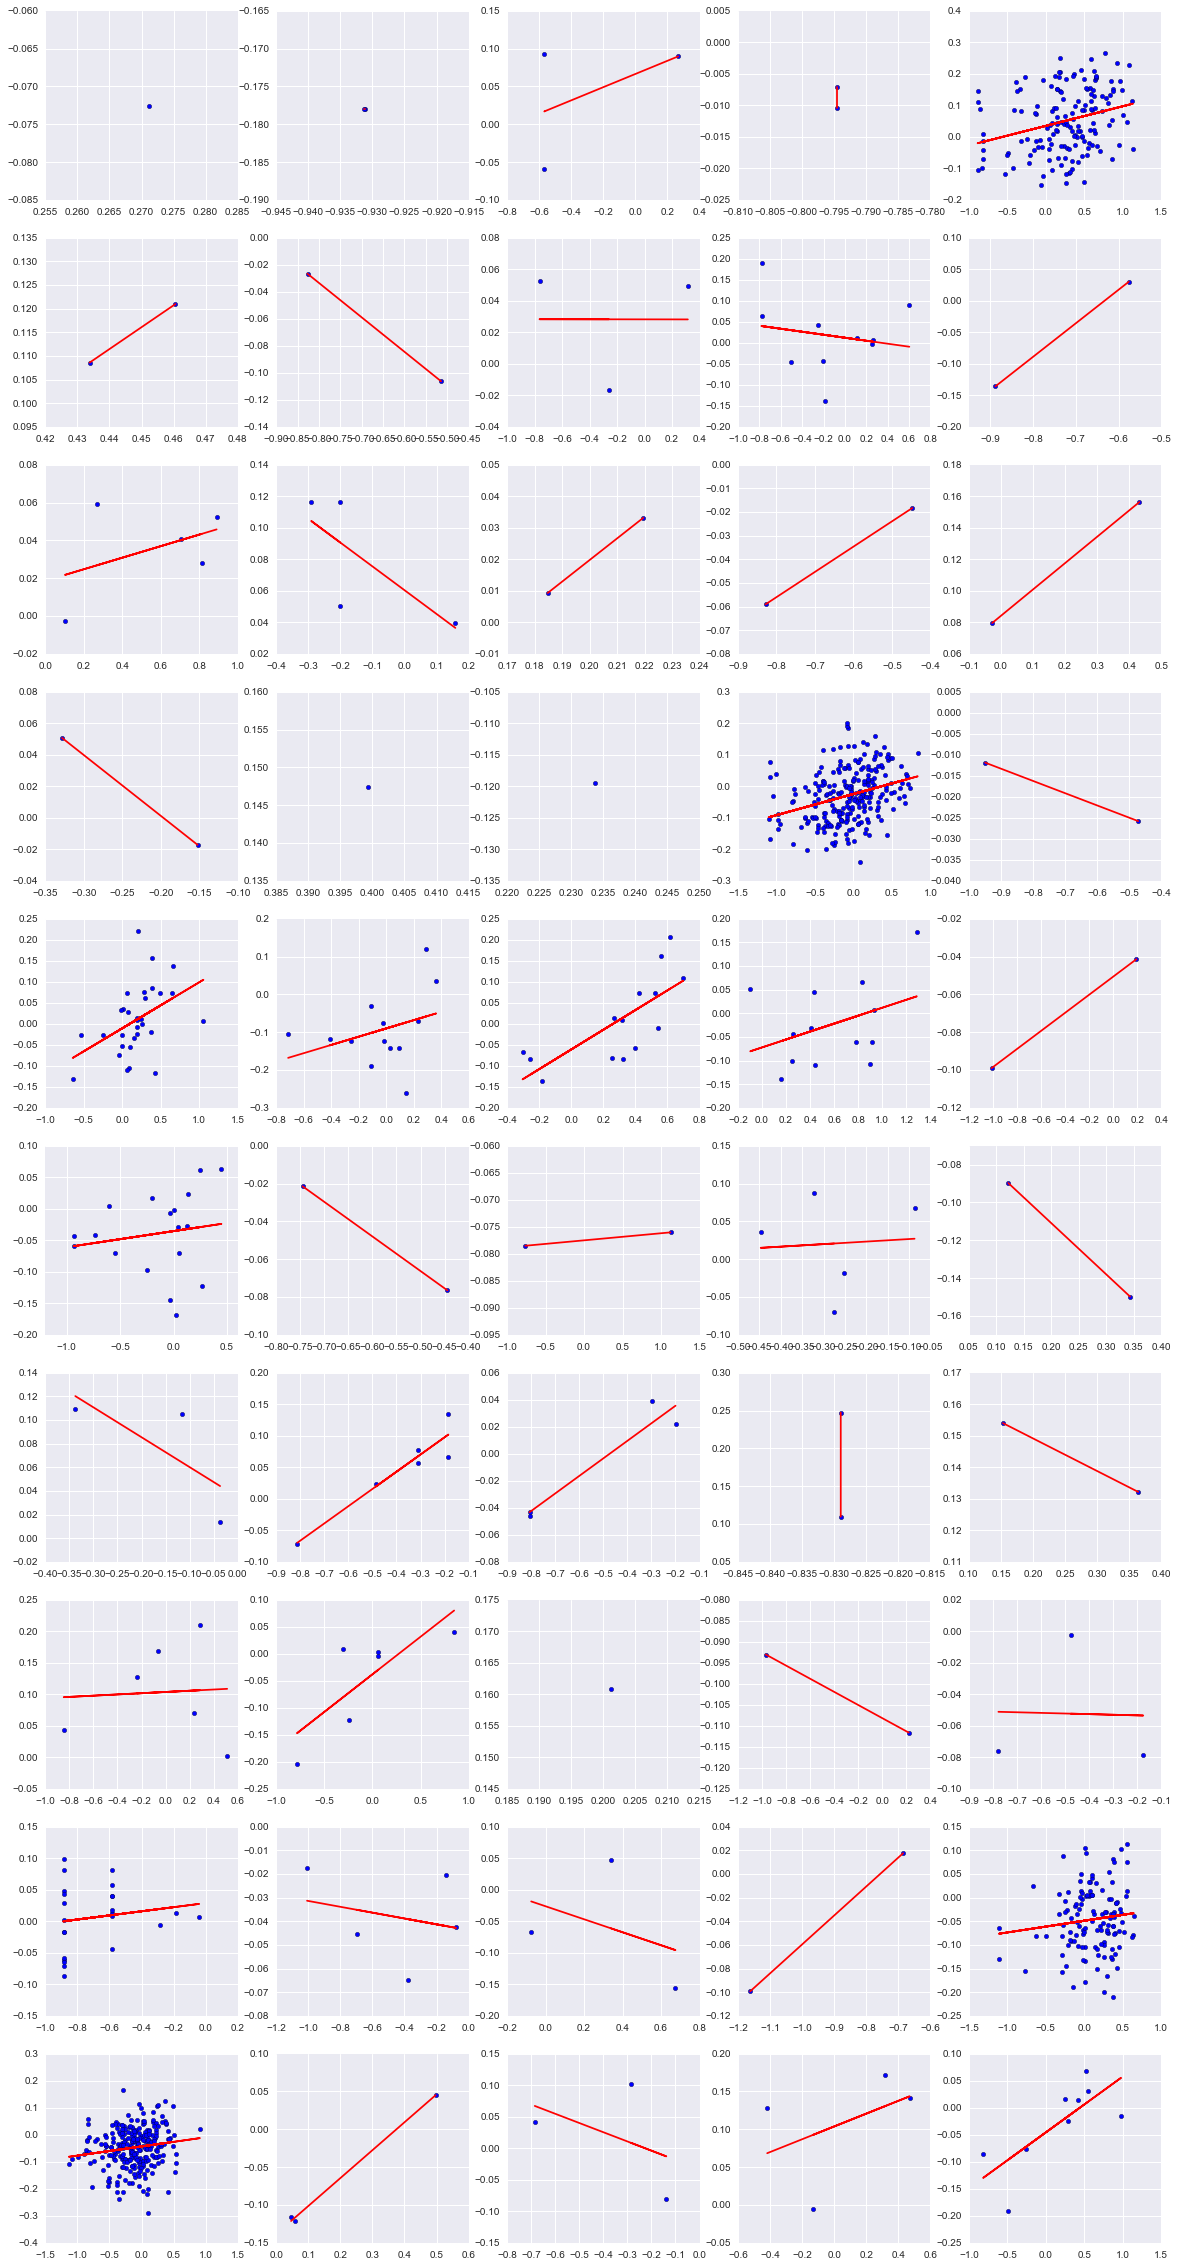

In [78]:
plt.figure(figsize=(20, 40))
for i in range(50):
    plt.subplot(10, 5, i+1)
    user_test_set = np.any(user_hot[:, [test_users[i]]], axis = 1).nonzero()[0]
    ypred = gbr.predict(predictors[user_test_set,:])

    y = np.ravel(likes[user_test_set])
    plt.scatter(y, ypred)
    print('rmse:' + str(calculate_rmse(y, ypred)))

    lin = linear_model.LinearRegression()
    lin.fit(y.reshape((-1, 1)), ypred)
    plt.plot(y, y * lin.coef_ + lin.intercept_, 'r')
    print("r^2: " + str(lin.score(y.reshape(-1,1), ypred)))

In [35]:
user_validation.shape

(1592, 5863)

In [54]:
ypred[0] == ypred[1]

True

In [58]:
ypred.shape

(154,)

In [64]:
y

array([ 0.85994042,  0.22986998,  0.14548724,  0.38047012,  1.05820212,
       -0.31853691,  0.22845376,  0.62063128, -0.3278888 , -0.40988412,
        1.13227489,  0.58926104,  1.08472694, -0.0339336 , -0.81151106,
        0.59686396, -0.12197873,  0.42020333, -0.39278452,  0.62916831,
        0.57039229,  0.72468151,  0.19290767,  0.17871793, -0.81109829,
        0.47030679, -0.83556841,  0.6442881 , -0.05659623,  0.65052732,
        0.86034889,  0.59244335,  0.18884489,  0.197882  ,  0.54240573,
        0.55949517,  0.50141934,  0.65523095,  0.33558468,  0.30265587,
        0.86610295,  0.60413799,  0.18708932,  0.14481851,  0.49908506,
       -0.8870059 ,  0.77331067,  0.09401522,  0.05875341,  0.26166738,
        0.265303  ,  0.06180643,  0.92217943,  0.57041074,  0.31776332,
        0.1161739 , -0.49858064,  0.9590351 , -0.1400105 , -0.04239194,
        1.11840792,  0.46835598,  0.07406822,  0.2427277 ,  0.37607305,
        0.24135711,  0.38449396, -0.05922065,  0.66093281,  0.64

In [65]:
ypred

array([ 0.05497388, -0.02809399,  0.15170464,  0.09854821,  0.04743364,
       -0.01143161,  0.12156928,  0.13044015,  0.08140642,  0.08619008,
       -0.03798516,  0.24627882,  0.22747671,  0.18106672, -0.04300141,
        0.08476784,  0.0733351 ,  0.03592816,  0.1744404 ,  0.20832106,
        0.02174626,  0.08109604,  0.04702561,  0.24927701, -0.0705798 ,
       -0.06052143, -0.09971308,  0.18092063, -0.0328835 ,  0.18823474,
       -0.06887209,  0.13623012,  0.20724651, -0.02850384, -0.03614213,
       -0.01917292, -0.14153678,  0.19046394,  0.0173416 , -0.11435274,
        0.15119991, -0.02474918,  0.14469609,  0.01906885,  0.08476541,
       -0.10506549,  0.26754867,  0.00812427,  0.03676673, -0.1469688 ,
       -0.11795136, -0.02195476,  0.23380226,  0.15535349,  0.03153332,
        0.19417087, -0.05035815,  0.17775923,  0.0750143 , -0.12474266,
        0.11284803, -0.00151692,  0.0807896 ,  0.06648065, -0.02543195,
        0.04127197,  0.00660761, -0.15413143, -0.02994339,  0.19

In [68]:
lin = linear_model.LinearRegression()

In [75]:
lin.fit(y.reshape((-1, 1)), ypred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

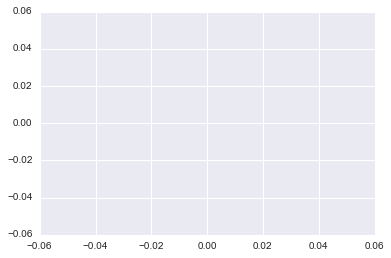

In [89]:
plt.plot(np.cumsum(cumulative_mean_likes_for_user[:,:])[-1])

In [87]:
np.mean(train_label[user_train[:,14] == 1] - pred_likes[user_train[:,14] == 1])

0.090416074610923589

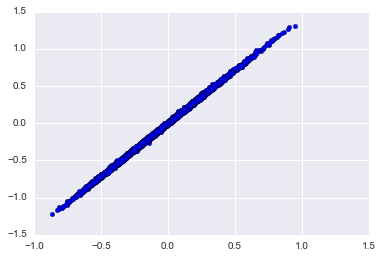

In [101]:
plt.scatter(np.cumsum(cumulative_mean_likes_for_user, axis=1)[:,-1], [np.mean(train_label[user_train[:,j] == 1] - pred_likes[user_train[:,j] == 1]) for j in range(5863)])

In [98]:
# this is a much tighter distribution than i would have expected/hoped
# this implies that i am not finding much significnat variation from the mean of each users's photos in the estimation process
# possible solutions:
    # slower descent on mean estimation?
        # perhaps by training the gradient boosted tree model more? or less?
        

(68168, 5863)

In [102]:
(training_set, train_data, train_label, user_train, validation_data, validation_label, user_validation, test_users) = split_datasets(users, user_hot, predictors, likes, seed=5)

Seed value is: 5
Training set length: 68168
Test set length: 1817
Validation set length: 1592


In [103]:
pred_likes = train_label * 0

for j in range(user_train.shape[1]):
    like_error = np.mean(train_label[user_train[:,j] == 1] - pred_likes[user_train[:,j] == 1])
    train_label[user_train[:,j] == 1] -= like_error
#     cumulative_mean_likes_for_user[j, i] += like_error * 0.1

In [104]:
gbr2 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=200, max_depth=3, warm_start=True, verbose=1)

cumulative_mean_likes_for_user = np.zeros((5863,20))

gbr2.fit(train_data, np.ravel(train_label))

      Iter       Train Loss   Remaining Time 
         1           0.1426          120.96m
         2           0.1421          107.48m
         3           0.1417          101.19m
         4           0.1413          102.67m
         5           0.1410          114.06m
         6           0.1407          118.79m
         7           0.1405          119.98m
         8           0.1403          116.30m
         9           0.1401          114.91m
        10           0.1399          113.48m
        20           0.1386           96.93m
        30           0.1376           91.19m
        40           0.1368           82.26m
        50           0.1361           75.92m
        60           0.1355           70.48m
        70           0.1349           65.02m
        80           0.1344           59.66m
        90           0.1338           55.15m
       100           0.1334           50.09m


KeyboardInterrupt: 